In [1]:
import os
os.chdir('../../')
import fff
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
matplotlib.rcParams.update({'font.size': 18})

INFO: Using pytorch backend
/tmp/ipykernel_4168541/735068933.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [79]:
classifier = True

In [87]:
if classifier:
    df = pd.read_pickle("data/Mnist_Class")
else:
    df = pd.read_pickle("data/Mnist_AE_data")
# read targets and conditions from dataframe
train_data, train_targets = (
    torch.from_numpy(df["train_x"]),
    torch.from_numpy(df["train_y"]),
)

center = torch.mean(train_targets)
std = torch.std(train_targets)

In [80]:
if classifier:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/fff_class/version_5/checkpoints/last.ckpt"
    )
else:
    model = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/nm_e42/version_0/checkpoints/last.ckpt"
    )

cond_dim:  10
latent_dim:  54
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
[64, 256, 256, 64]
Sequential(
  (0): ConvolutionalNeuralNetwork(
    (model): Sequential(
      (encoder): Sequential(
        (0): Unflatten(dim=-1, unflattened_size=(11, 8, 8))
        (1): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): ReLU()
        (7): Flatten(start_dim=-3, end_dim=-1)
        (8): Linear(in_features=1024, out_features=54, bias=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=64, out_features=4256, bias=True)
        (1): Unflatten(dim=-1, unflattened_size=(266, 4, 4))
        (2): ConvTranspose2d(266, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (

In [81]:
torch.set_grad_enabled(False)

encoding...
torch.Size([5000, 54])
decoding...
decoding...


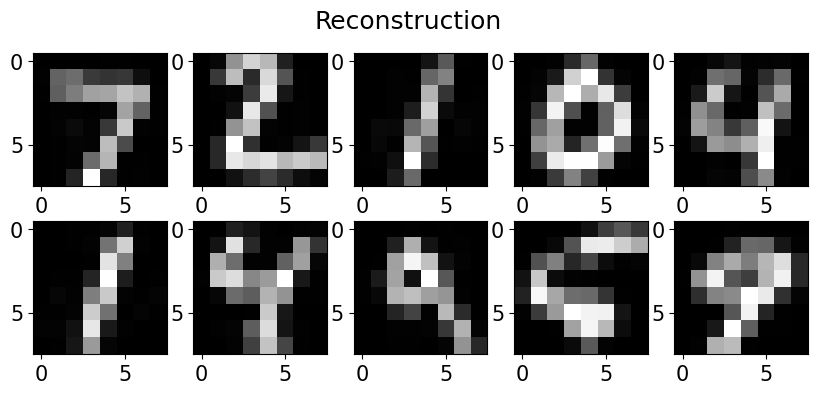

tensor(0.5260)


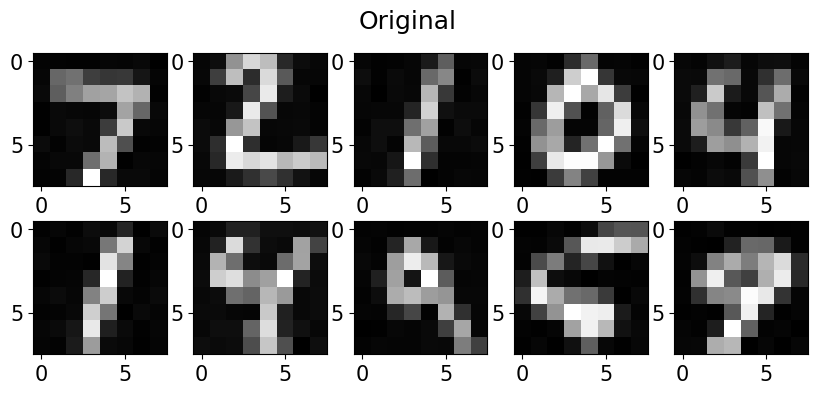

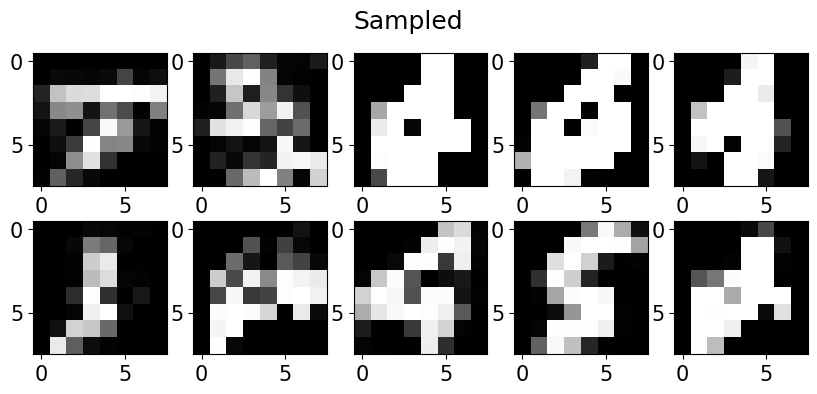

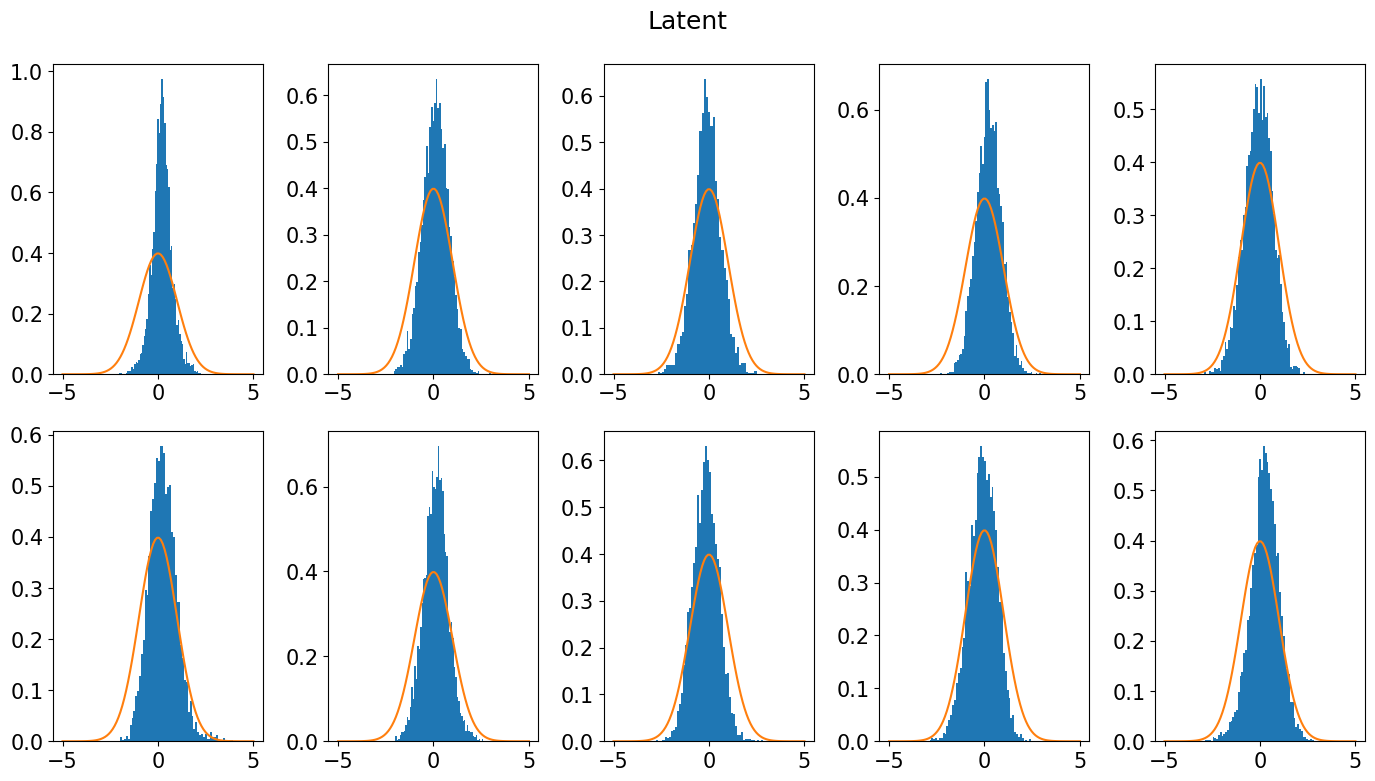

In [82]:
data = plot_mnist(model)
z_val = data["val_z"]
std_main = torch.std(z_val[:,0])
print(std_main)

ValueError: too many values to unpack (expected 3)

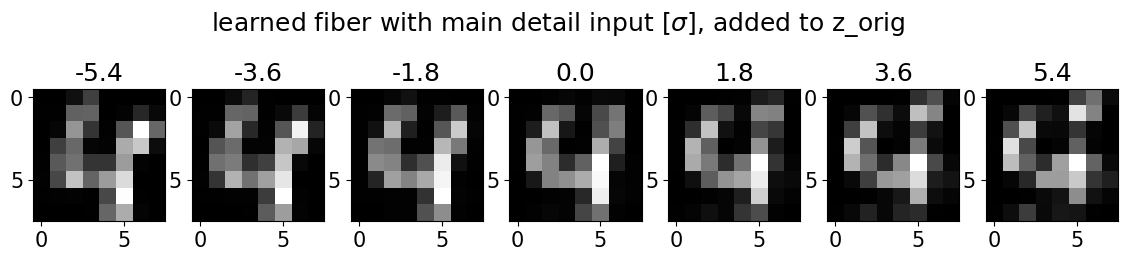

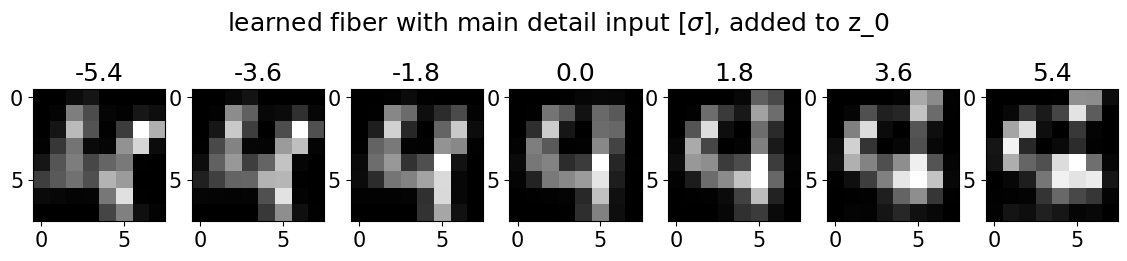

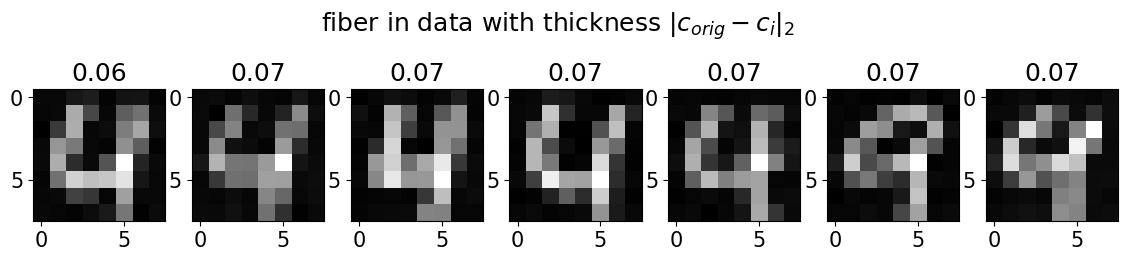

In [67]:
x0, x1, c_orig = plot_details(model, data, 4, 6*std_main)

/tmp/ipykernel_4168541/2840581147.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))


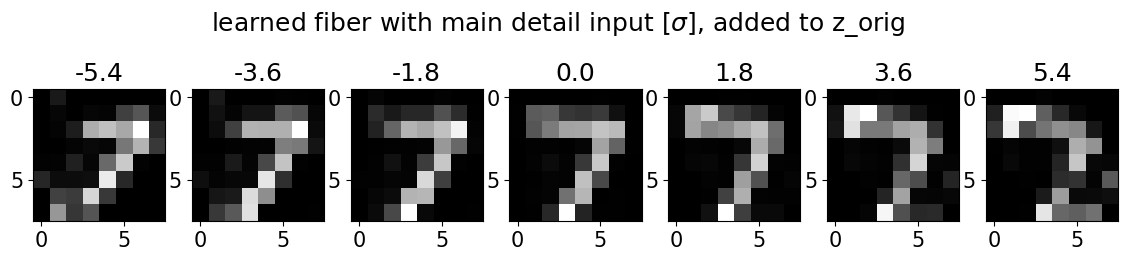

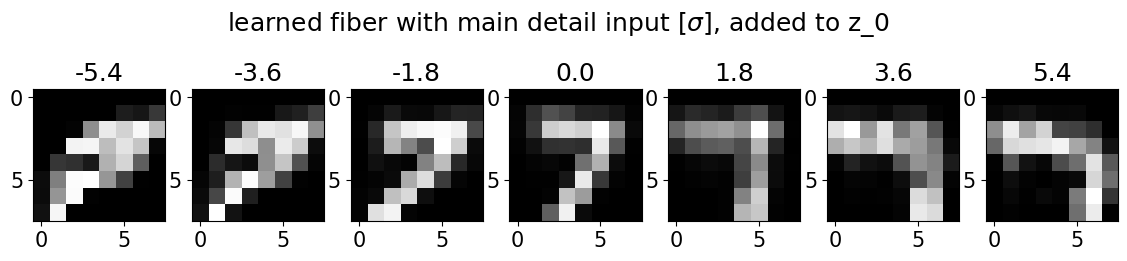

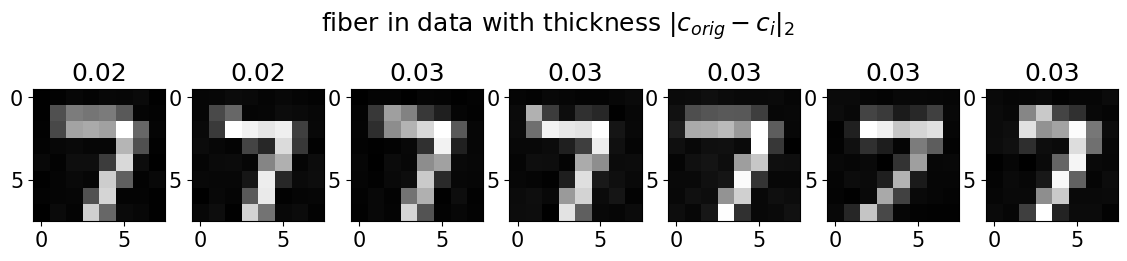

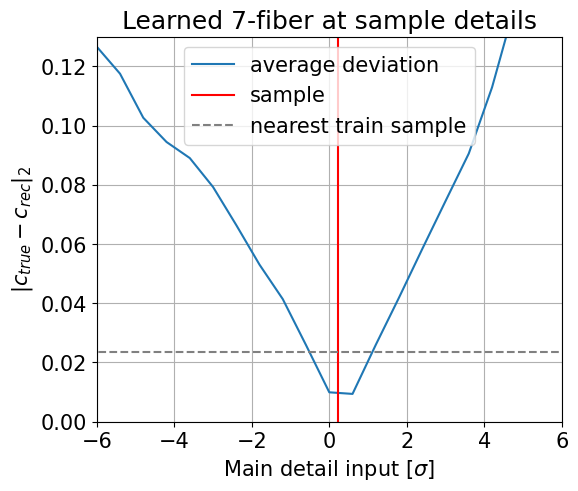

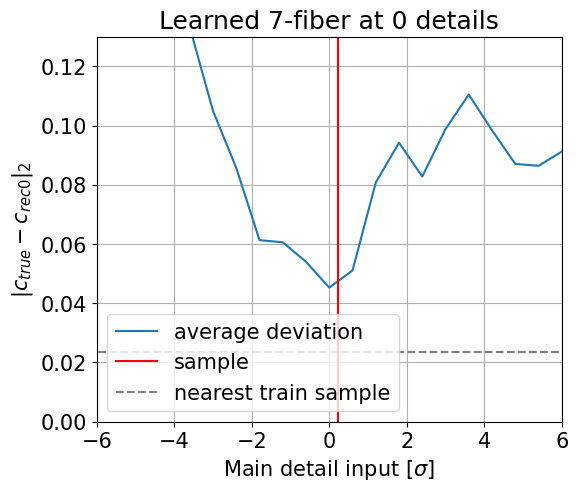

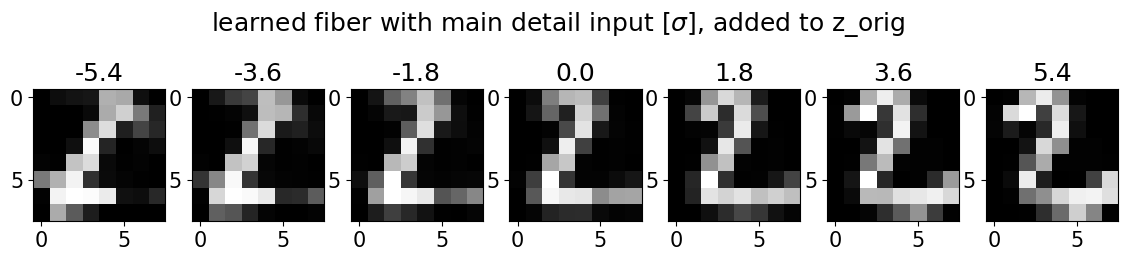

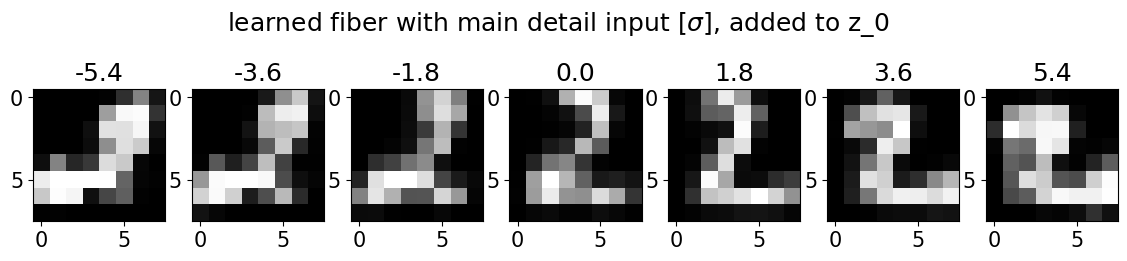

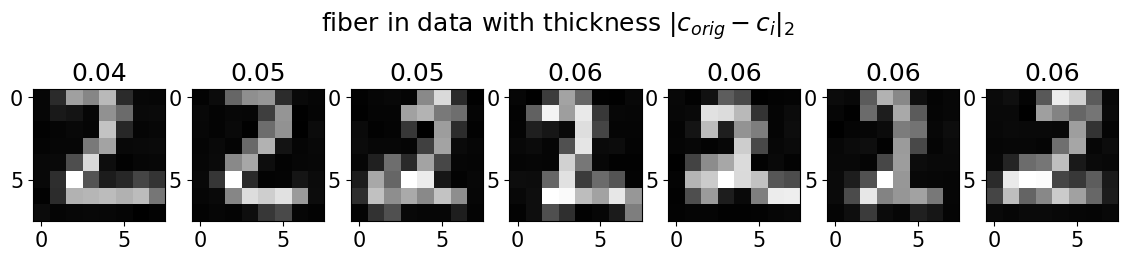

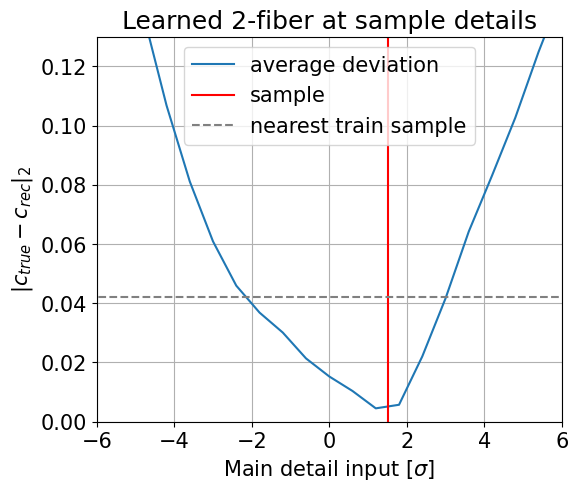

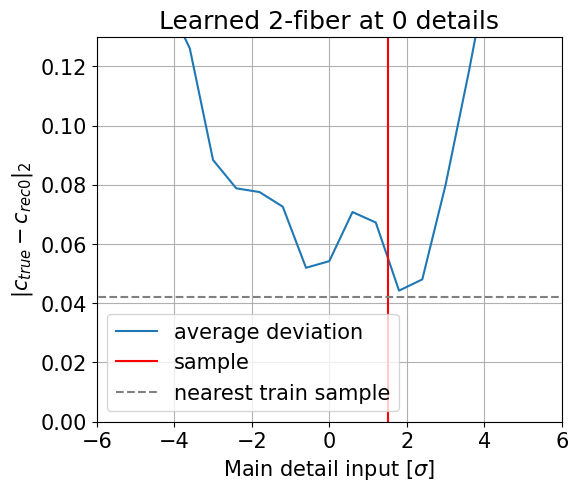

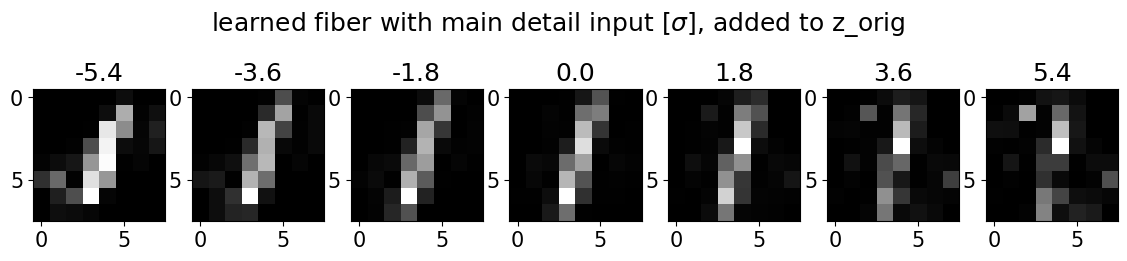

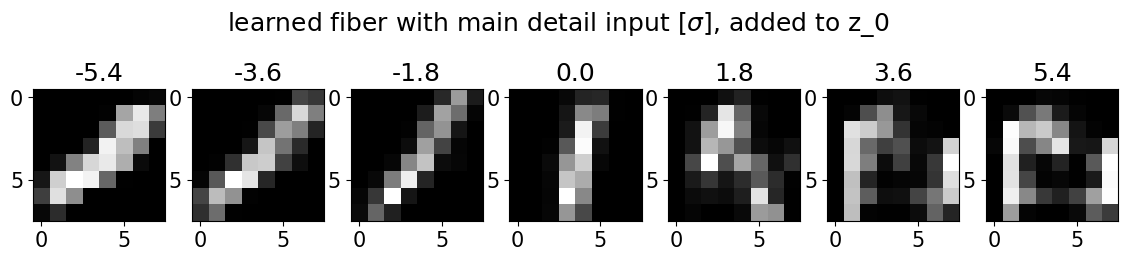

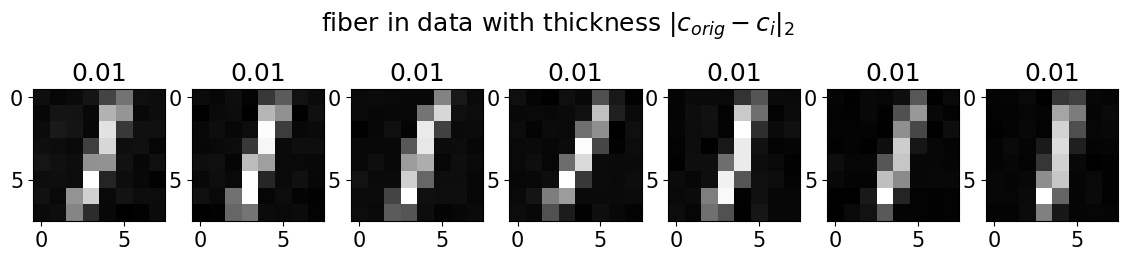

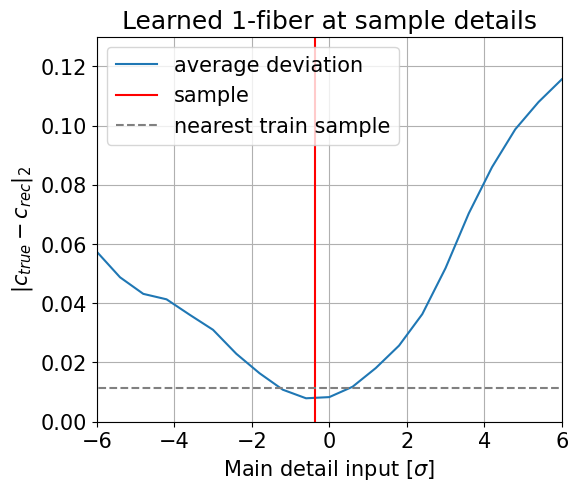

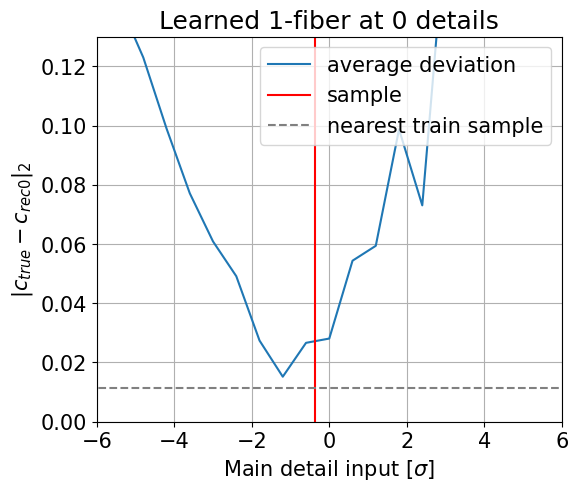

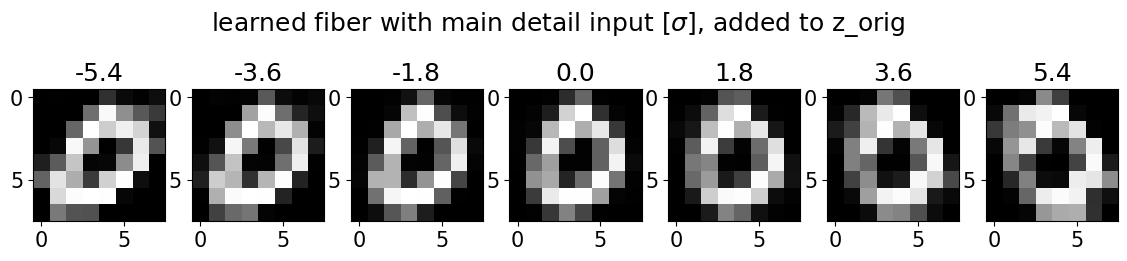

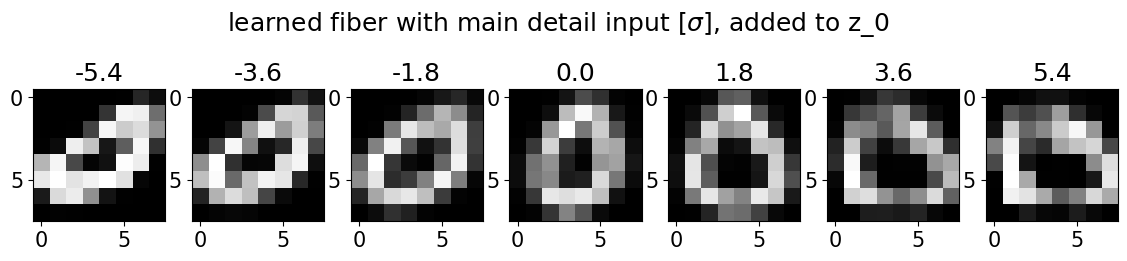

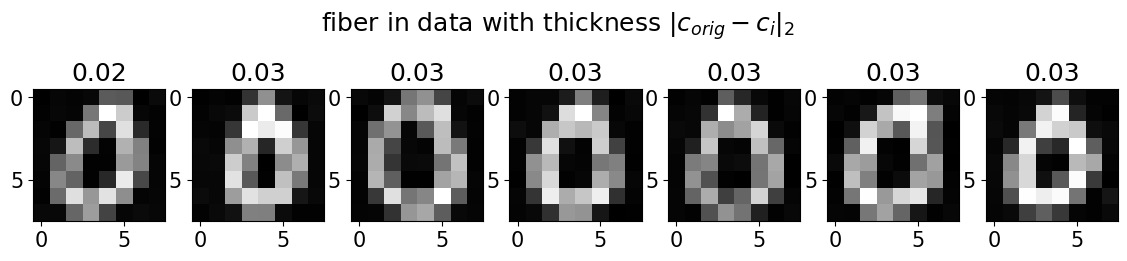

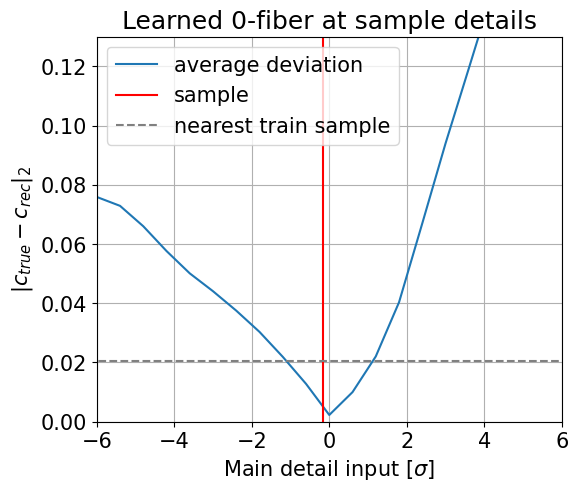

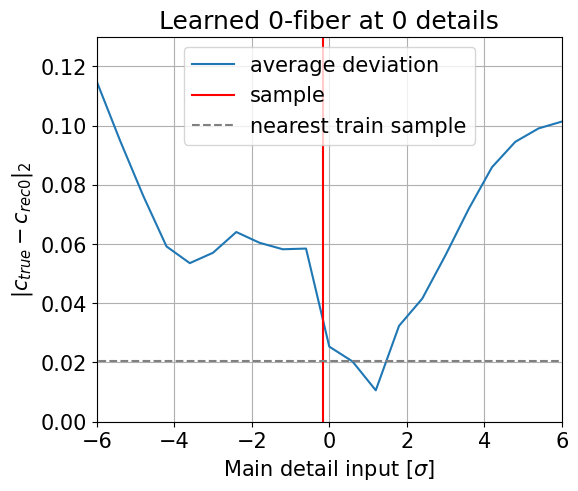

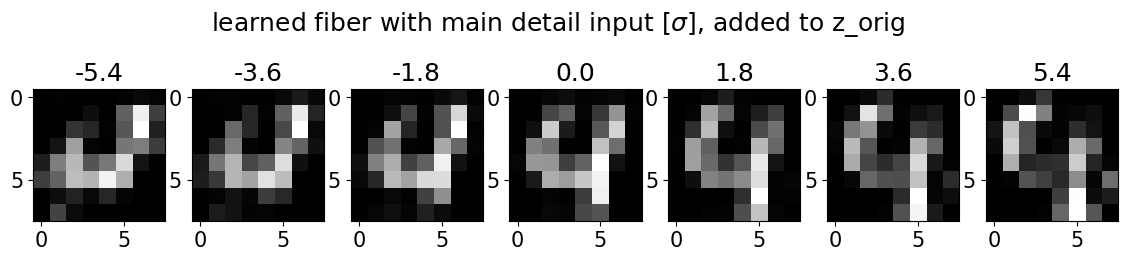

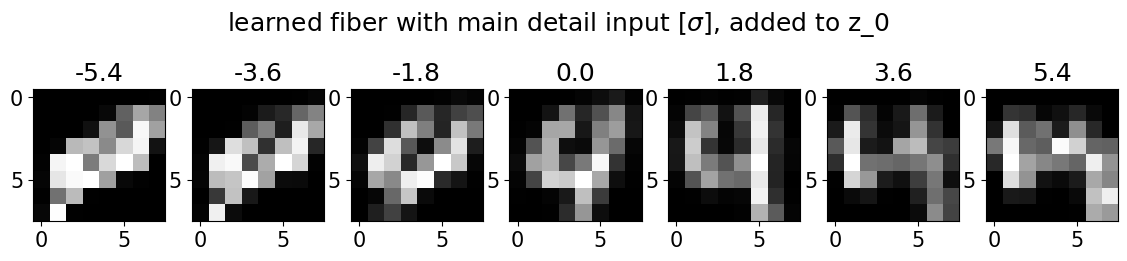

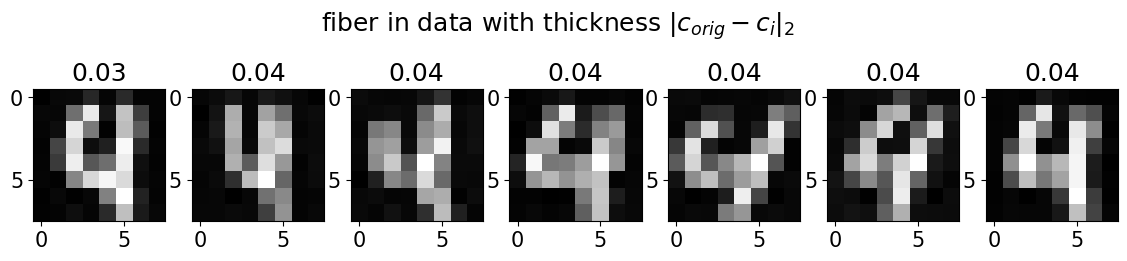

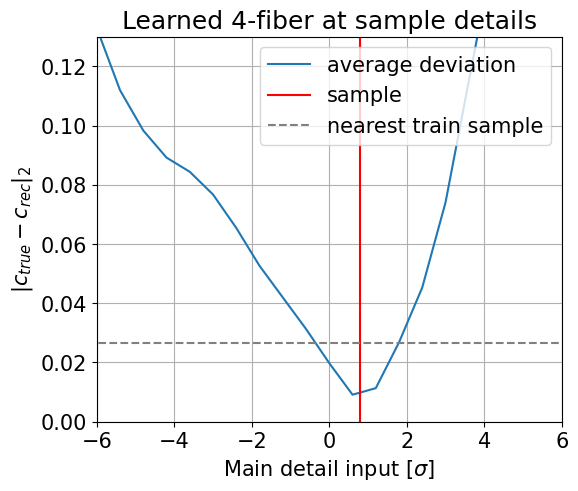

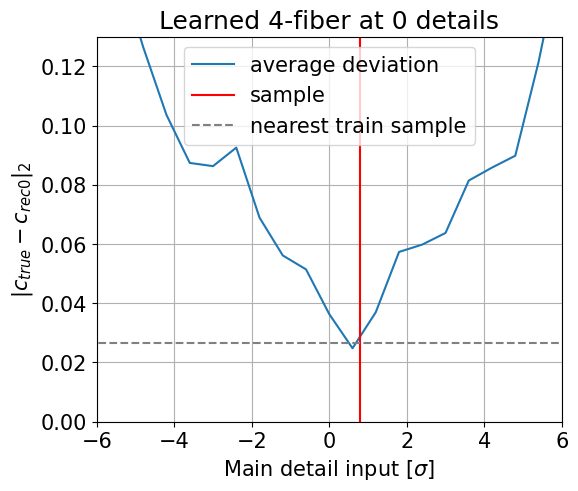

In [88]:
drange = 6*std_main
matplotlib.rcParams.update({'font.size': 15})
nums = [7,2,1,0,4]
for j in range(5):
    x0, x1, c_orig, d0, NN = plot_details(model, data, j, drange)
    for i, xi in enumerate([x1, x0]):
        if classifier == False:
            conditioned = GT.apply_conditions((xi,))
            c = conditioned.condition
            x = conditioned.x0
            fibre_true = (GT.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        else:
            conditioned = GT.apply_conditions((xi,c_orig))
            x = conditioned.x0
            c = torch.empty((x.shape[0], 0), device=x.device, dtype=x.dtype)
            fibre_true = (Features.encode(x.to(GT.device), c.to(GT.device)).cpu() - center) / std
        
        #print(torch.max(fibre_true-c_orig, dim=1)[0])
        delta_coarse = torch.sqrt(torch.sum((fibre_true-c_orig)**2, dim=1)).numpy()/10
        
        plt.figure(figsize=[6,5])
        delta_details = np.linspace(-drange,drange,21)/std_main
        plt.plot(delta_details,delta_coarse, label="average deviation")
        plt.axvline(x=d0/std_main, ymin=0, ymax=2,color='red', label='sample')
        plt.axhline(y=NN, xmin=-10, xmax=10, color='gray', linestyle="--", label='nearest train sample')
        if i == 0:
            plt.title(f"Learned {nums[j]}-fiber at sample details")
            plt.ylabel(r"$|c_{true}-c_{rec}|_2$")
        else:
            plt.title(f"Learned {nums[j]}-fiber at 0 details")
            plt.ylabel(r"$|c_{true}-c_{rec0}|_2$")
        plt.legend()
        plt.xlabel(r"Main detail input [$\sigma$]")
        plt.ylim((0,0.13))
        plt.xlim((-drange/std_main,drange/std_main))
        plt.grid()
        plt.savefig(f"plots/class_nocrec/{1-i}deviation{nums[j]}.png")


In [58]:
def plot_details(rectangular_flow, data, sample, drange):
    device = rectangular_flow.device
    c = data["val_c"]
    c_train = data["train_c"]
    train_samples = data["train_samples"]
    z = data["val_z"]
    N = 21
    n = 7
    
    pos_min, pos_max = -drange, drange
    detail = torch.linspace(pos_min, pos_max, N)
    detail_l = []
    d0 = z[sample][0]
    for i in range(N):
        d = z[sample].clone()
        d[0] = detail[i]
        detail_l.append(d)
    details1 = torch.stack(detail_l)
    
    details0 = torch.zeros(N,53)
    details0 = torch.cat([torch.unsqueeze(detail,1), details0], dim=1)
    condition = torch.unsqueeze(c[sample], dim=0)
    condition = condition.repeat(N,1)
    x_details1 = rectangular_flow.decode(details1.to(device), condition.to(device)).cpu()
    x_details0 = rectangular_flow.decode(details0.to(device), condition.to(device)).cpu()


    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details1[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title((detail[i*N//n+1]/std_main).numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_orig")
    
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(x_details0[i*N//n+1].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title((detail[i*N//n+1]/std_main).numpy().round(1))
    plt.suptitle(r"learned fiber with main detail input [$\sigma$], added to z_0")

    verify = c[sample]
    diff = c_train - verify
    squared_diff = torch.sqrt(torch.sum(torch.square(diff), dim =1))
    ind = torch.argsort(squared_diff)[:n]
    #print("squared distance between chosen sample and nearest trein samples:", squared_diff[ind]/10)
    similar = train_samples[ind]

    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(similar[i].cpu().reshape(8, 8), cmap='gray')
        axes[i].set_title(np.round(squared_diff[ind[i]].numpy()/10,2))
    fig.suptitle(r"fiber in data with thickness $|c_{orig}-c_i|_2$")
    NN = squared_diff[ind[0]].numpy()/10
    
    return x_details0, x_details1, condition, d0, NN

In [14]:
from fff.evaluate.plots import all_conditions
def plot_mnist(rectangular_flow):
    data = {}
    train_batch = rectangular_flow.train_data[:]
    val_batch = rectangular_flow.test_data[:5000]

    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x0
    c_train = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_batch)
    #print(val_batch[1][:10])
    c_val = conditioned.condition
    val_samples = conditioned.x0
    
    #print(c.shape)
    #print(val_samples.shape)
    data["train_samples"] = train_samples
    data["val_c"] = c_val
    data["train_c"] = c_train
    
    device = rectangular_flow.device
    
    print("encoding...")
    batch_size = rectangular_flow.hparams.batch_size
    #print(batch_size)
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_val.split(batch_size))
    ])
    
    data["val_z"] = z_val
    print(z_val.shape)
    print("decoding...")
    x1_val = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_val.split(batch_size), c_val.split(batch_size))
    ])
    z_test = torch.randn_like(z_val)
    print("decoding...")
    x1_test = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c_val.split(batch_size))
    ])
    #print(x1_test.shape)

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x1_val[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Reconstruction")
    plt.show()
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(val_samples[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Original")

    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(2):
        for j in range(5):
            axes[i][j].imshow(x1_test[i*5 +j].cpu().reshape(8, 8), cmap='gray')
    fig.suptitle("Sampled")

    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))
    a = np.linspace(-5,5,100)
    for i in range(2):
        for j in range(5):
            axes[i][j].hist(z_val[:,i*5+j], bins=60, label="Samples", density=True)
            axes[i][j].plot(a, normal(a))
    fig.suptitle("Latent")
    fig.tight_layout()

    return data

In [8]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

In [84]:
if classifier:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
        "lightning_logs/classifier/version_2/checkpoints/last.ckpt"
    )
else:
    GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/downsampled/version_5/checkpoints/last.ckpt"
    )

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
Sequential(
  (0): ConvolutionalNeuralNetwork(
    (model): Sequential(
      (encoder): Sequential(
        (0): Unflatten(dim=-1, unflattened_size=(1, 8, 8))
        (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): ReLU()
        (7): Flatten(start_dim=-3, end_dim=-1)
        (8): Linear(in_features=1024, out_features=10, bias=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=10, out_features=4096, bias=True)
        (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
        (2): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

In [18]:
GT = fff.FreeFormInjectiveFlow.load_from_checkpoint(
    "lightning_logs/downsampled/version_5/checkpoints/last.ckpt"
)

torch.Size([60000, 1, 8, 8])
cond_dim:  0
latent_dim:  10
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
[10, 256, 256, 10]
Sequential(
  (0): ConvolutionalNeuralNetwork(
    (model): Sequential(
      (encoder): Sequential(
        (0): Unflatten(dim=-1, unflattened_size=(1, 8, 8))
        (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): ReLU()
        (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (6): ReLU()
        (7): Flatten(start_dim=-3, end_dim=-1)
        (8): Linear(in_features=1024, out_features=10, bias=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=10, out_features=4096, bias=True)
        (1): Unflatten(dim=-1, unflattened_size=(256, 4, 4))
        (2): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output

torch.Size([10000, 10])
torch.Size([10000])


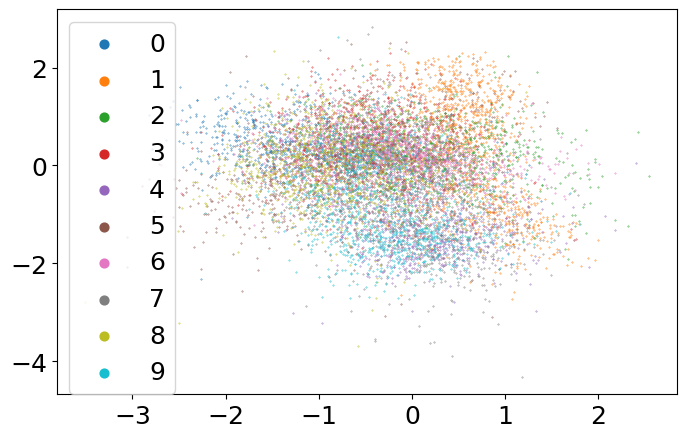

In [28]:
plt.figure(figsize=[8,5])
z = (torch.from_numpy(df["val_y"]) - center) / std
val_data = GT.val_data[:]
conditioned = GT.apply_conditions(val_data)
t = conditioned.condition
y = np.argmax(t,axis=1)
print(z.shape)
z0 = z[:,6]
z1 = z[:,7]
print(y.shape)
for i in range(10):
    z0i = z0[y==i]
    z1i = z1[y==i]
    plt.scatter(z0i,z1i, s=0.1, label=i)
plt.legend(markerscale=20.)

In [85]:
from fff.model.utils import guess_image_shape
class Truncate(torch.nn.Module):
            def __init__(self):
                super(Truncate, self).__init__()
                enc_conv = list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[0]
                enc_res = list(
                    list(
                    list(
                    list(
                    list(
                        GT.children()
                    )[1].children()
                    )[1].children()
                    )[0].children()
                    )[0].children()
                    )[:-2]
                self.features = torch.nn.Sequential(
                    enc_conv, *enc_res
                )

            def cat_x_c(self, x, c):
                # Reshape as image, and concatenate conditioning as channel dimensions
                has_batch_dimension = len(x.shape) > 1
                if not has_batch_dimension:
                    x = x[None, :]
                    c = c[None, :]
                batch_size = x.shape[0]
                input_shape = guess_image_shape(GT.data_dim)
                x_img = x.reshape(batch_size, *input_shape)
                c_img = c[:, :, None, None] * torch.ones(batch_size, GT.cond_dim, *input_shape[1:], device=c.device)
                out = torch.cat([x_img, c_img], -3).reshape(batch_size, -1)
                if not has_batch_dimension:
                    out = out[0]
                return out
            
            def encode(self, x, c):
                x = self.features(self.cat_x_c(x,c))
                return x

Features = Truncate()

In [11]:
save_data(model)

encoding traindata...
encoding valdata...
encoding testdata...


In [10]:
def save_data(rectangular_flow):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x_noisy
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x_noisy
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x_noisy
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    path = "Mnist_AE"
    fileName = path + 'ML_data'
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()